<a href="https://colab.research.google.com/github/project-ccap/project-ccap.github.io/blob/master/2023notebooks/2020_0712tlpa_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CCAP Project

- title: 転移学習による TLPA 画像認識
- author: 浅川伸一
- filename: `2020-0712tlpa_resnet18.ipynb`
- last date: 2020-0713
- note:
    - 使用モデル: ResNet-18, 論文: https://arxiv.org/abs/1512.03385
    - データ: TLPA 図版 大門正太郎 先生より

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

import sys
import numpy as np
import json
import random
from PIL import Image as PILImage
import matplotlib.pyplot as plt
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

import skimage.color  # for gray2rgb()
from scipy.special import logsumexp, softmax
from termcolor import colored

import torchvision
from torchvision import models, transforms
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

# PyTorch バージョン確認
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print(f'device: {device}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=3a3ec9cf4d9d9fb7352da8e92e2a54a5be29683f28219ce56039fb3f8eac40a0
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib
PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118
device: cpu


In [2]:
# 各モデルを定義し，訓練済み結合係数をダウンロードする
DNNs = {}
DNNs['resnet18'] = models.resnet18(weights='DEFAULT', progress=True)
#DNNs['resnet18'] = models.resnet18(pretrained=True, progress=True)
# DNNs['alexnet'] = models.alexnet(pretrained=True, progress=True)
# DNNs['vgg16'] = models.vgg16(pretrained=True, progress=True)
# DNNs['squeezenet']= models.squeezenet1_0(pretrained=True, progress=True)
# DNNs['densenet'] = models.densenet161(pretrained=True, progress=True)
# DNNs['inception'] = models.inception_v3(pretrained=True, progress=True)
# DNNs['googlenet'] = models.googlenet(pretrained=True, progress=True)
# DNNs['shufflenet'] = models.shufflenet_v2_x1_0(pretrained=True, progress=True)
# DNNs['mobilenet'] = models.mobilenet_v2(pretrained=True, progress=True)
# DNNs['resnext50_32x4d'] = models.resnext50_32x4d(pretrained=True, progress=True)
# DNNs['wide_resnet50_2'] = models.wide_resnet50_2(pretrained=True, progress=True)
# DNNs['mnasnet'] = models.mnasnet1_0(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


In [3]:
# 上の中から試したいモデルを選んでください。最後のモデルが有効になります。
net = DNNs['resnet18']
#net = DNNs['squeezenet']
#net = DNNs['googlenet']
#net = DNNs['shufflenet']
#net = DNNs['mobilenet']
#net = DNNs['vgg16']
#net = DNNs['alexnet']

a_parameters = {name:param for name, param in net.named_parameters()}
a_modules = {name:param for name, param in net.named_modules()}

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor()])

# RGB 各チャンネルの平均と分散の定義。CNN 唯一の前処理
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

normalize = transforms.Normalize(mean=mean, std=std)

In [ ]:
# サンプル画像の入手
import os
if not os.path.exists('test.img'):
    !wget -O test.img https://github.com/ShinAsakawa/ShinAsakawa.github.io/raw/master/assets/CIMG0568.JPG

image_file = 'test.img'
img = PILImage.open(image_file)
plt.axis(False); plt.imshow(img); plt.show()


In [ ]:
# 認識するための準備で画像を変形
img_ = transform(img)
plt.axis(False); plt.imshow(img_.numpy().transpose((1, 2, 0))); plt.show()

In [9]:
try:
    import ccap
except ImportError:
    !git clone https://github.com/project-ccap/ccap.git
    import ccap
from ccap import imagenetDataset

Cloning into 'ccap'...
remote: Enumerating objects: 6823, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 6823 (delta 51), reused 93 (delta 37), pack-reused 6705
Receiving objects: 100% (6823/6823), 618.61 MiB | 39.29 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Updating files: 100% (5717/5717), done.


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
imagenet = imagenetDataset()

for _ in range(3):
    num = np.random.choice(len(imagenet))
    imagenet.sample_and_show(num)

In [ ]:
# 出力結果からラベルを予測する後処理クラス
class ImageNetPredictor():
    """
    ImageNet データに対するモデルの出力からラベル出力

    Attributes:
        class_index : dictionary
        クラス index とラベル名 を対応させた辞書型変数
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        最大値を与える ImageNet ラベル名を返す

        Parameters:
            out : torch.Size([1, 1000])  Net からの出力

        Returns:
            predicted_labels: [str]
            最も予測確率が高いラベルの名前
        """
        outnp = out.detach().numpy()
        ids = np.argsort(- outnp)
        predicted_labels = [self.class_index[id] for id in ids[0]]

        return ids[0], predicted_labels, softmax(outnp)

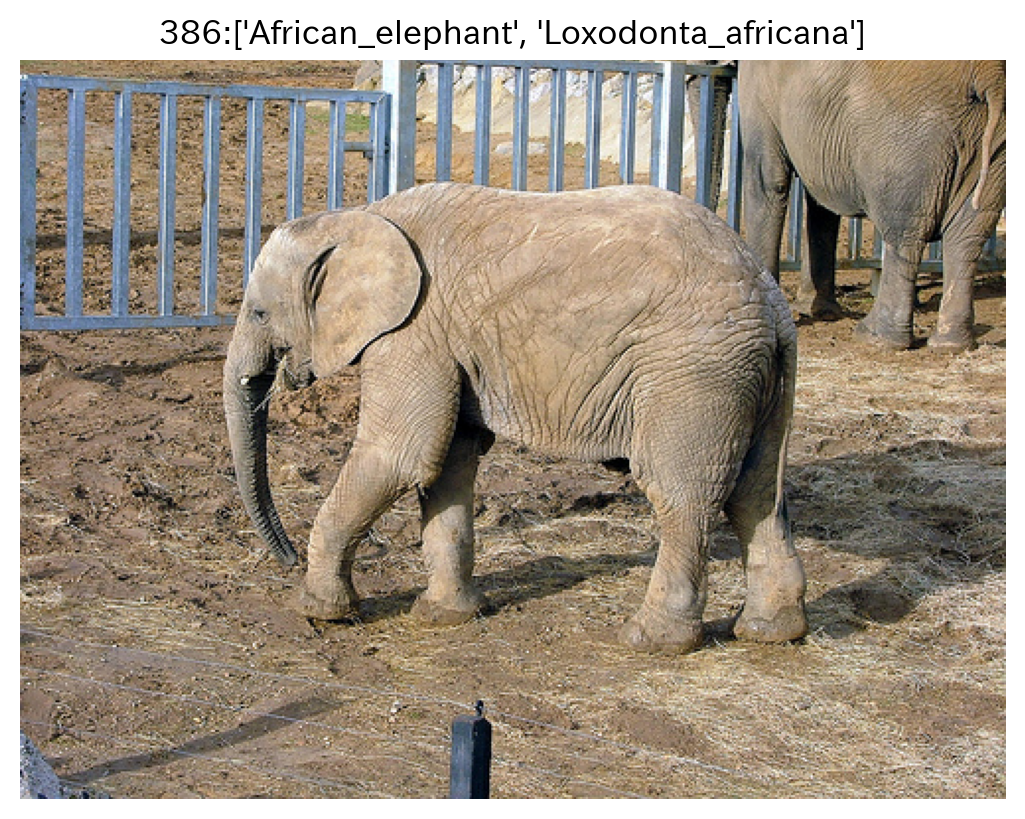

In [26]:
# 下の no は 0 から 999 まで 1000 の ImageNet class に対応
no = np.random.choice(len(imagenet))
#print(f'no:{no}, ラベル:{imagenet.data[no]["label"]}')
img_file = imagenet.sample_image(no)
img = PILImage.open(img_file)
plt.title(f'{no}:{imagenet.data[no]["label"]}')
plt.axis(False); plt.imshow(img); plt.show()

In [27]:
# 認識の実施
inputs = transform(img).unsqueeze_(0)  # torch.Size([1, 3, 224, 224])
out = net(inputs)  # torch.Size([1, 1000])

outnp = out.detach().numpy()
ids = np.argsort( - outnp)

n_best = 3
print(ids[0][:n_best])
for no in ids[0][:n_best]:
    print(imagenet(int(no))[1], end=" ")
    print(imagenet.getitem_from_wnid(imagenet(int(no))[1])['label'], end=" ")
    print(imagenet.getitem_from_wnid(imagenet(int(no))[1])['label_ja'], end=" ")
    print(imagenet.getitem_from_wnid(imagenet(int(no))[1])['definition'])


[463 600 731]
n02909870 ['bucket', 'pail'] ['バケット', 'バケツ', '井戸釣瓶', '手桶', '桶', '水おけ', '水桶', '洗い桶', '洗桶', '片手桶', '猿頬', '荷い', '荷ない', '釣瓶', '麻笥'] a roughly cylindrical vessel that is open at the top
n03532672 ['hook', 'claw'] ['フック', 'ホック', '引っかかり', '引っ掛かり', '引っ掛り', '引掛', '引掛かり', '手かぎ', '手鉤', '爪', '鉤'] a mechanical device that is curved or bent to suspend or hold or pull something
n03970156 ['plunger', "plumber's_helper"] [] hand tool consisting of a stick with a rubber suction cup at one end; used to clean clogged drains


In [28]:
# 乱数のシードを設定
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [29]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる
class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時は RandomResizedCrop と RandomHorizontalFlip で データ拡張


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.8, 1.0)),  # データ拡張
                transforms.RandomHorizontalFlip(),  # データ拡張
                transforms.RandomAffine(degrees=(-20,20), translate=None, scale=[0.9,1.1]),
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

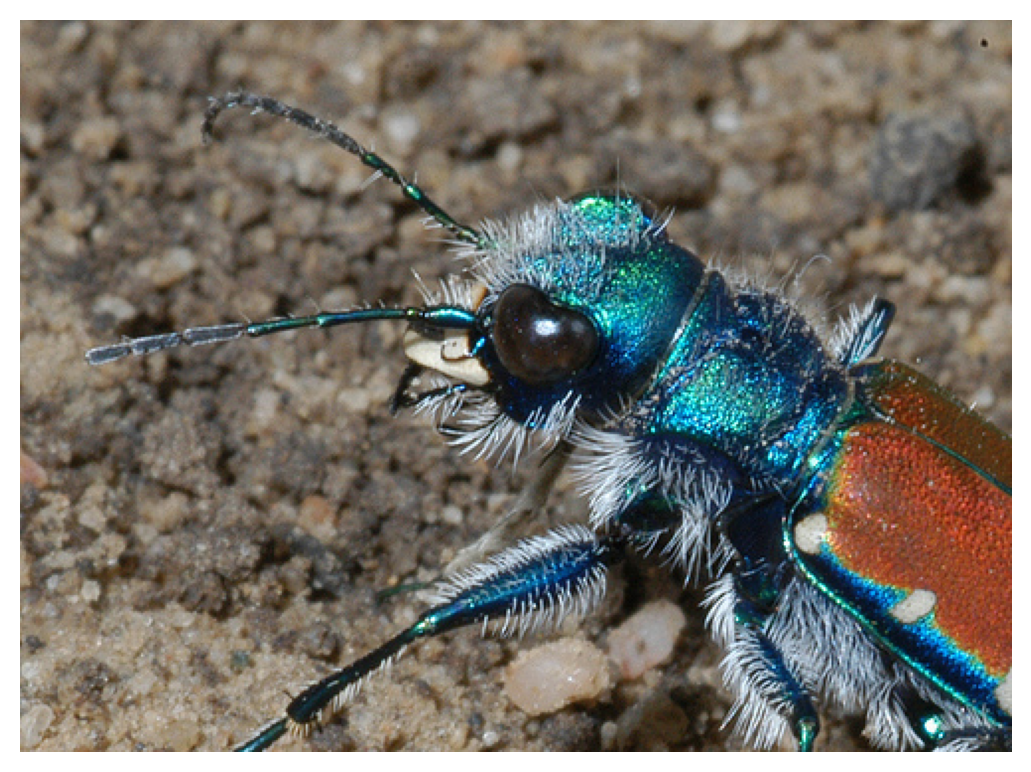

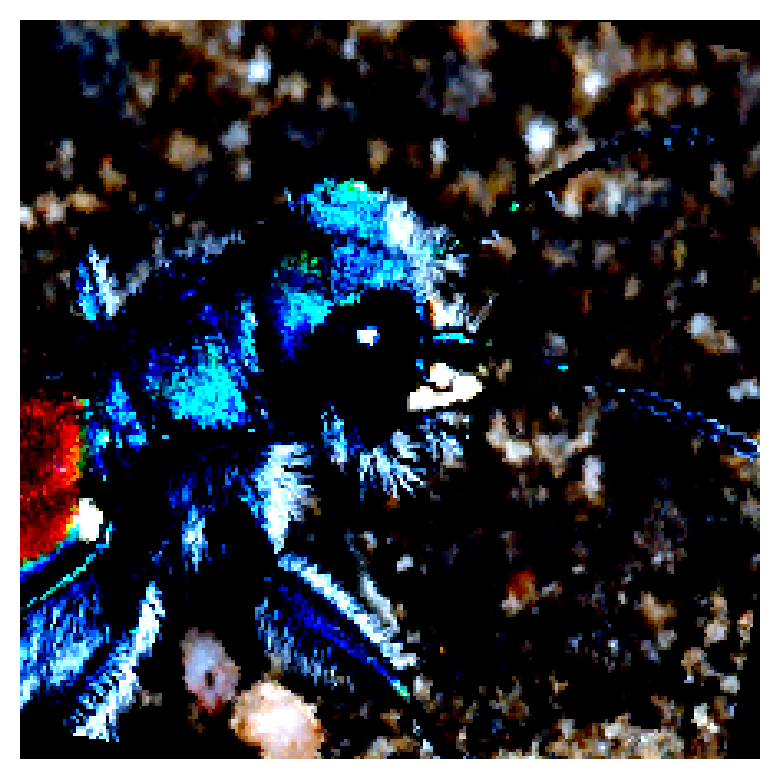

In [30]:
# 訓練時の画像前処理の動作を確認

# 画像読み込み
no = 300
img_file, label = imagenet(no)
img = PILImage.open(img_file)   # [高さ][幅][色RGB]

# 元画像の表示
plt.axis(False); plt.imshow(img); plt.show()

# 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.axis(False); plt.imshow(img_transformed); plt.show()

In [31]:
from ccap import tlpaDataset

tlpa = tlpaDataset()
tlpa_img_path = [tlpa.data[k]['img'] for k in tlpa.data.keys()]
tlpa.data.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179])

In [32]:
# tlpa_name_dict = {i:tlpa.data[k]['Name'] for i, k in enumerate(tlpa.data)}  # N.G. str 型のラベル名では動作しない
tlpa_name_dict = {i:k for i, k in enumerate(tlpa.data.keys())}
print(tlpa_name_dict)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 119, 120: 120, 121: 121,

In [33]:
# Dataset の作成
class tlpa_torch_Dataset(data.Dataset):
    """
    TLPA 画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, name_dict, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定
        self.namedict = name_dict

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = PILImage.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        label = self.namedict[index]
        return img_transformed, label


train_dataset = tlpa_torch_Dataset(file_list=tlpa_img_path,
                                   name_dict=tlpa_name_dict,
                                   transform=ImageTransform(size, mean, std),
                                   phase='train')

val_dataset = tlpa_torch_Dataset(file_list=tlpa_img_path,
                                 name_dict=tlpa_name_dict,
                                 transform=ImageTransform(size, mean, std),
                                 phase='val')

# 動作確認
index = 3
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
print(train_dataset.__len__())

torch.Size([3, 224, 224])
3
180


In [34]:
# ミニバッチのサイズを指定
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([110,   1,   4,  85,  87,   7, 111,   3,  28, 151, 108, 128, 104,  68,
         97, 171,  31,  71, 155, 149,  83, 127, 147,  60,   9,  12, 131,  67,
         15,  86,  42,  49])


In [ ]:
# モデルのインスタンスを生成し，事前学習済の結合係数をロード
use_pretrained = True  # 学習済みのパラメータを使用
net = models.resnet18(weights='DEFAULT')
#net = models.resnet18(pretrained=use_pretrained)
net.eval()

In [36]:
# モデルの最終直下層の出力ユニット数を TLPA に合わせて 180 にする
net.fc = nn.Linear(in_features=512, out_features=180)

# 訓練モードに設定
net.train();

In [37]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [ ]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["fc.weight", "fc.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)

In [39]:
# 最適化手法の設定
#optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
#help(optim.Adam)
#optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
optimizer = optim.Adam(params=params_to_update)

In [40]:
# モデルを学習させる関数
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epochのループ
    for epoch in range(num_epochs):
        print(f'エポック {epoch+1}/{num_epochs}')
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モード
            else:
                net.eval()   # モデルを検証モード

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            #for inputs, labels in tqdm(dataloaders_dict[phase]):
            # tqdm は要らん。冗長な出力になるだけ
            for inputs, labels in dataloaders_dict[phase]:
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [41]:
for inputs, labels in dataloaders_dict['train']:
    print(inputs.size(), labels)
    output = net(inputs)
    loss = criterion(output, labels)

torch.Size([32, 3, 224, 224]) tensor([133, 116, 105,  36,  59,  95,  39,  70,  31,  79, 117,  34, 115, 151,
        101, 124,  91, 157,  97, 132, 154, 112,  42,  71, 148, 136,  93, 107,
        153,  21,  64,  50])
torch.Size([32, 3, 224, 224]) tensor([156,  26,  74, 170, 143,  81, 142,  46,  37,  89, 173, 127,  55, 104,
         10, 145,  57,   3, 177,   2,  84, 159,  23, 128, 138,  60,   0,  75,
         20,  77, 162,  27])
torch.Size([32, 3, 224, 224]) tensor([ 73, 167, 140,  85, 103, 113, 161,  94,  54,  35,  30,  83, 174, 129,
        155, 176, 150, 169,   7, 108,  98,   6,  58,  80,   1,  18, 122,  53,
        130, 139, 118,  88])
torch.Size([32, 3, 224, 224]) tensor([  8,  48, 106,  76,  29,  44,  38,  41, 131,  45,  40,   5, 126, 172,
        114,  14,  33, 119,  56,  16, 102,  72, 146,  47, 121,  67,  25, 123,
        109, 175,  11, 147])
torch.Size([32, 3, 224, 224]) tensor([ 32,  62,  19, 163,  92,  68, 110,  17, 171, 160,  22,  51,  28, 164,
         99,  82,  24,  87, 100,

In [45]:
from google.colab import files
files.upload()


Saving 2020-0712tlpa_resnet18_weights.pth to 2020-0712tlpa_resnet18_weights.pth


In [ ]:
# 保存してある訓練済モデルを読み込む
saved_weight_file = '2020-0712tlpa_resnet18_weights.pth'
load_weights = torch.load(saved_weight_file)
net.load_state_dict(load_weights)
net.eval()

In [48]:
%%time
# 学習・検証を実行する
#num_epochs=1
#train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

saved_weight_file = '2023-0624lpa_resnet18_weights.pth'
saved_weight_file = '2020-0712tlpa_resnet18_weights.pth'
#torch.save(net.state_dict(), saved_weight_file)
load_weights = torch.load(saved_weight_file)
net.load_state_dict(load_weights)

CPU times: user 21 ms, sys: 21.7 ms, total: 42.7 ms
Wall time: 96.4 ms


<All keys matched successfully>

In [49]:
#save_weight_file = '2020-0712tlpa_vgg16_weights.pth'
#torch.save(net.state_dict(), save_weight_file)

load_weights = torch.load(saved_weight_file)
net.load_state_dict(load_weights)

<All keys matched successfully>

In [ ]:
# 1. 画像読み込み
no = 18
img, label = tlpa(no)
img = PILImage.open(img)   # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img); plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="val")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed_ = img_transformed.numpy().transpose((1, 2, 0))
img_transformed_ = np.clip(img_transformed_, 0, 1)
plt.imshow(img_transformed_);plt.show()


In [ ]:
#float_formatter = "{:.3f}".format
#np.set_printoptions(formatter={'float_kind':float_formatter})
# see https://note.nkmk.me/python-numpy-set-printoptions-float-formatter/
np.set_printoptions(formatter={'int': '{:3d}'.format, 'float_kind':'{:.3f}'.format})

def diagnose(no, display=False, n_best=5):
    img, label = tlpa(no)
    img = PILImage.open(img)   # [高さ][幅][色RGB]

    # 元の画像の表示
    #if display:
    #    plt.imshow(img); plt.show()

    # 画像の前処理と処理済み画像の表示
    size = 224
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    transform = ImageTransform(size, mean, std)
    img_transformed = transform(img, phase="val")  # torch.Size([3, 224, 224])

    # (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
    if display:
        img_transformed_ = img_transformed.numpy().transpose((1, 2, 0))
        img_transformed_ = np.clip(img_transformed_, 0, 1)
        plt.imshow(img_transformed_);plt.show()

    # 認識の実施
    inputs = transform(img, phase='val')
    inputs_ = inputs.unsqueeze_(0)
    out = net(inputs_)
    outnp = out.detach().numpy()
    ids = np.argsort( - outnp[0])
    sftmx = softmax(-outnp[0])
    #print(sftmx[ids[0]], sftmx[ids[1]], sftmx[ids[2]])
    #print(np.sort(sftmx)[:5])

    if no == ids[0]:
        print('Hit ', end="")
    else:
        print(colored('Miss', 'red'), end="")

    print(ids[:n_best], end=" ")
    for no in ids[:n_best]:
        print(tlpa.data[no]['Name'], end=" ")
    print(- np.sort(-sftmx)[:n_best])

for i in range(tlpa.__len__()):
    diagnose(i, display=False, n_best=5)

In [ ]:
tlpa.show_all_images()

In [ ]:
print(tlpa('動物園'))
tlpa.show_an_image('動物園')

In [ ]:
from ccap import imagenetDataset

In [ ]:
imagenet = imagenetDataset()

In [ ]:
imagenet.sample_and_show(799)

In [ ]:
imagenet.labels

In [ ]:
from ccap import salaDataset

sala = salaDataset()
sala_img_path = [sala.data[k]['img'] for k in sala.data.keys()]
sala.data.keys()

In [ ]:
import nltk
nltk.download('omw-1.4')

In [ ]:
sala.show_all_images()